In [1]:
import numpy as np
from birkeland import Model, BetterModel
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Reproduce the plots from Milan (2013)
The below code instantiates the two examples from Milan (2013) and attempts to reproduce the plots from Milan (2013).

In [2]:
example1 = Model(50, 0, 0.4)
example2 = Model(30, 70, 0.7)

## Reproduce Figure 2a–d

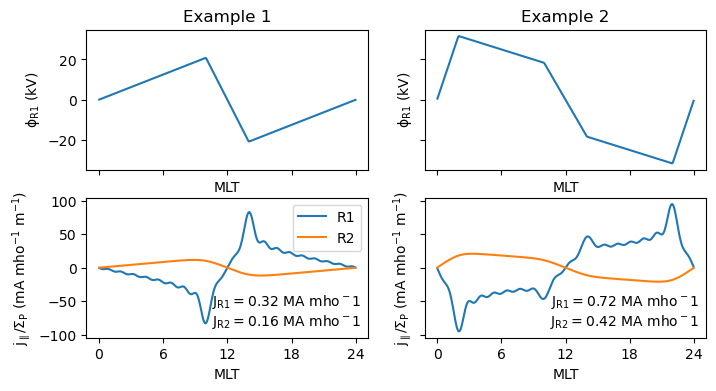

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharex="all", sharey="row")

for cnt, example in enumerate((example1, example2)):
    example.plot_r1_potential(ax[0, cnt])
    example.plot_r1_and_r2_intensity(ax[1, cnt])
    
ax[1, 0].legend(loc="upper right")
ax[0, 0].set(title="Example 1")
ax[0, 1].set(title="Example 2")

plt.show()

## Reproduce the contours in Figure 2e-j

The contours are at intervals of 10 kV from 5 kV upward; the 6 kV interval stated in the caption to Figure 2 is a typographical error.

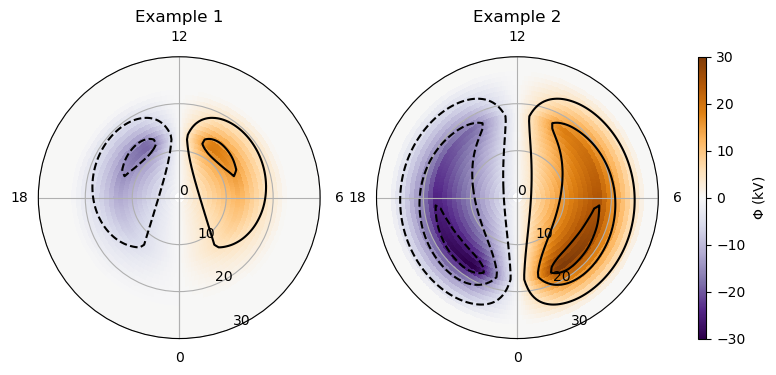

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = example.map_electric_potential(ax[cnt])
    ax[cnt].set_title(f"Example {cnt + 1}")

cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\mathregular{\Phi}$ (kV)")

## Reproduce the maps in Figures 2e-h

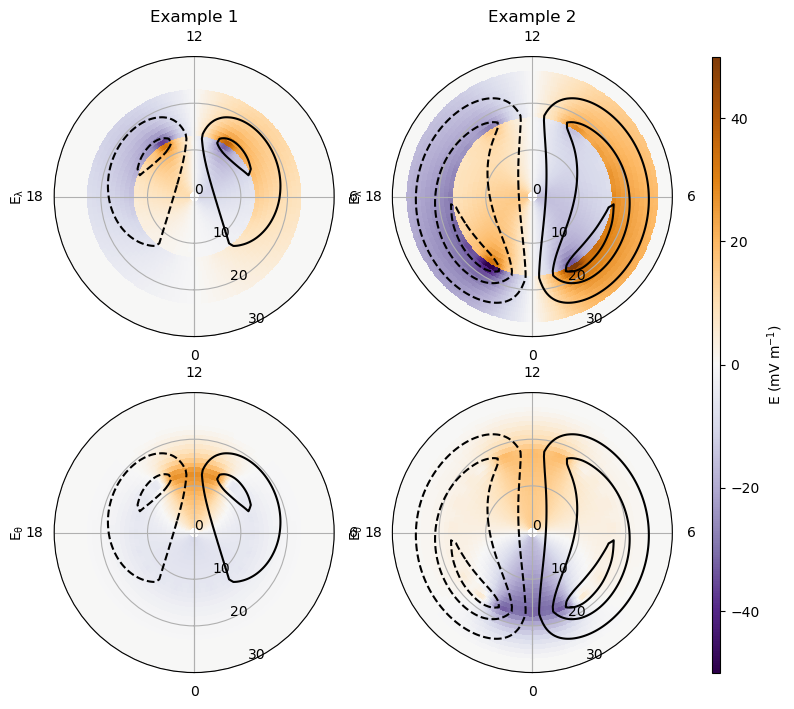

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for col, example in enumerate([example1, example2]):
    for row, component in enumerate(["labda", "theta"]):
        mesh[row, col] = example.map_electric_field(ax[row, col], component)
    ax[0, col].set_title(f"Example {col + 1}")
        
cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"E (mV m$^{-1}$)")

## Reproduce Figure 2i–j

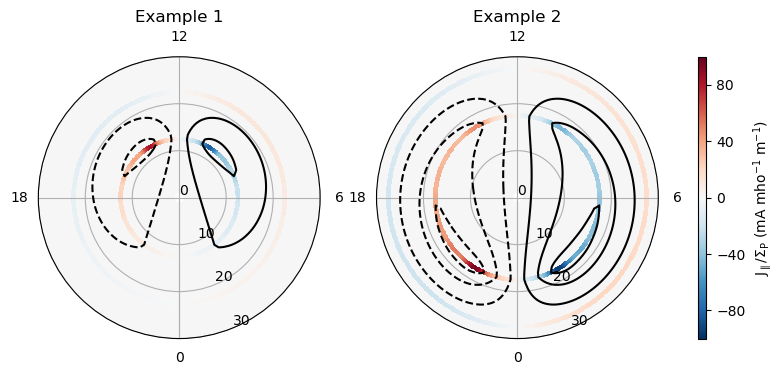

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = example.map_current(ax[cnt])
    ax[cnt].set_title(f"Example {cnt + 1}")

cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\mathregular{J_\parallel/\Sigma_P}$ (mA mho$^{-1}$ m$^{-1}$)")

## Plot the ionospheric flow vector

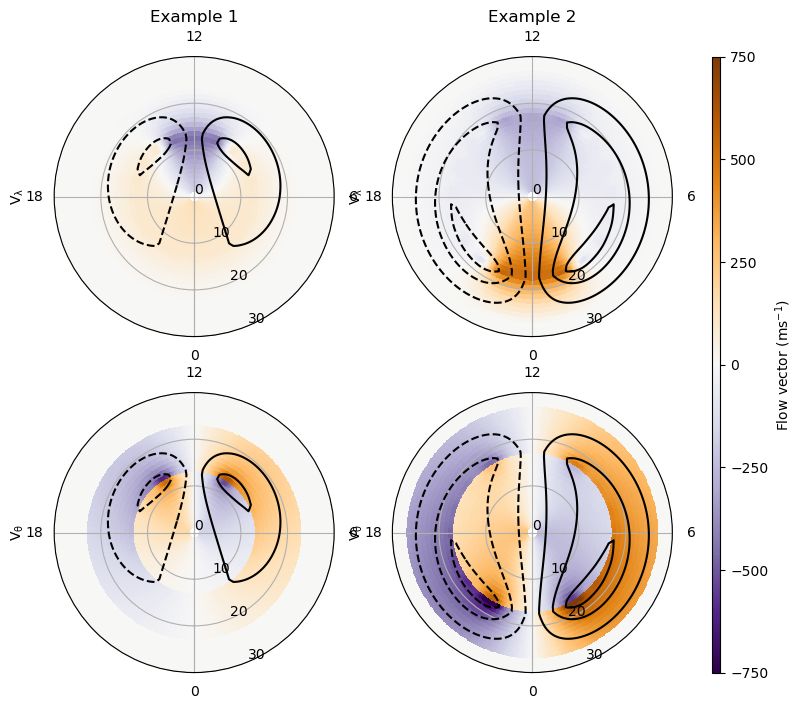

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for col, example in enumerate([example1, example2]):
    for row, component in enumerate(["labda", "theta"]):
        mesh[row, col] = example.map_flow_vector(ax[row, col], component)
    ax[0, col].set_title(f"Example {col + 1}")
    
cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"Flow vector (ms$^{-1}$)")

In [95]:
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astropy.time import Time

class BetterModel(Model):
    def __init__(self, phi_d, phi_n, f_107, time, hemisphere, sigma_h=12, sigma_p=7, **kwargs):
        """Milan (2013) model expanded with the Moen and Brekke (1993) model"""
        Model.__init__(self, phi_d, phi_n, **kwargs)

        self.f_107 = f_107
        self.time = time
        if hemisphere not in {"north", "south"}:
            raise ValueError("Hemisphere must be \"north\" or \"south\".")
        else:
            self.hemisphere = hemisphere

        self.sza = self.solar_zenith_angle()
        self.sigma_h, self.sigma_p = self.conductance(sigma_h, sigma_p)

    def conductance(self, rf_sigma_h, rf_sigma_p):
        sigma_h, sigma_p = self.quiet_time_conductance()

        # Set the Pedersen and Hall conductivities in the return flow region.
        _, _, _, mask = self.labda_by_region()
        sigma_h[mask, :] += rf_sigma_h
        sigma_p[mask, :] += rf_sigma_p

        return sigma_h, sigma_p

    def currents(self):
        div_jp = np.zeros_like(self.sigma_h)
        div_jh = np.zeros_like(self.sigma_h)

        for i, labda in enumerate(self.labda):
            if i == 0:
                continue
                
            for j, _ in enumerate(self.theta):
                # Pedersen current in latitude
                j_p = (2 * np.pi * self._r_e * np.sin(labda) / 180.) * \
                      (self.e_labda[i-1, j] * self.sigma_p[i-1, j]
                       - self.e_labda[i, j] * self.sigma_p[i, j])
                div_jp[0, j] += j_p / 2
                div_jp[i, j] += j_p / 2

                j_plus_1 = (j + 1) % 360

                # Pedersen current in longitude
                j_p = (2 * np.pi * self._r_e / 360.) * \
                      ((self.e_theta[i, j_plus_1] * self.sigma_p[i, j_plus_1])
                       - (self.e_theta[i, j] * self.sigma_p[i, j]))
                div_jp[i, j] += j_p / 2.
                div_jp[i, j_plus_1] += j_p / 2.

                # Hall current in latitude
                j_h = (2 * np.pi * self._r_e * np.sin(labda) / 180.) * \
                      ((self.e_theta[i-1, j] * self.sigma_h[i-1, j])
                       - (self.e_theta[i, j] * self.sigma_h[i, j]))
                
                div_jh[0, j] += j_h / 2
                div_jh[i, j] += j_h / 2

                # Hall current in longitude
                j_h = (2 * np.pi * self._r_e / 360) * \
                      ((self.e_labda[i, j_plus_1] * self.sigma_h[i, j_plus_1])
                       - (self.e_labda[i, j] * self.sigma_h[i, j]))
                                
                div_jh[i, j] += j_h / 2
                div_jh[i, j_plus_1] += j_h / 2

        fac = div_jp + div_jh

        return div_jp, div_jh, fac

    def quiet_time_conductance(self):
        """Quiet-time conductance calculated from Moen and Brekke (1993)."""
        sigma_h = np.zeros_like(self.sza)
        sigma_p = np.zeros_like(self.sza)

        day_mask = self.sza < np.pi / 2.
        sza_day = self.sza[day_mask]

        sigma_h[day_mask] = (self.f_107 ** 0.53) * ((0.81 * np.cos(sza_day))
                                                    + (0.54 * np.sqrt(np.cos(sza_day))))
        sigma_p[day_mask] = (self.f_107 ** 0.49) * ((0.34 * np.cos(sza_day))
                                                    + (0.93 * np.sqrt(np.cos(sza_day))))

        return sigma_h, sigma_p

    def solar_zenith_angle(self):
        """Calculate the solar zenith angle using AstroPy."""
        time = Time(self.time)

        lat_grid = 90 - np.broadcast_to(self.colat, (self._n_theta, self._n_labda)).T
        lon_grid = 15 * np.broadcast_to(self.mlt, (self._n_labda, self._n_theta))
        alt_grid = np.ones_like(lat_grid) * 780

        if self.hemisphere == "south":
            lat_grid *= -1

        loc = EarthLocation.from_geodetic(lon_grid, lat_grid, alt_grid)
        altitude_azimuth = AltAz(obstime=time, location=loc)
        angle = get_sun(time).transform_to(altitude_azimuth).zen.radian

        return angle


In [96]:
import datetime as dt
model = BetterModel(8.09364, 8.09364, 78.8214, dt.datetime(2010,1,1), "north", f_pc=0.3)

In [107]:
div_jh, div_jp, fac = model.currents()

In [98]:
from scipy.io import readsav

sav = readsav("/Users/John/Desktop/3_1_17.sav")

In [104]:
sav

{'e_lambda': array([[-1.7341951e-04, -1.7636410e-04, -1.8232483e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-3.4662418e-04, -3.5248109e-04, -3.6433601e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-5.1939953e-04, -5.2810455e-04, -5.4572127e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        ...,
        [ 3.4662374e-04,  3.5248062e-04,  3.6433546e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [ 1.7342001e-04,  1.7636466e-04,  1.8232547e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-8.6717522e-10, -8.6874402e-10, -8.7239954e-10, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]], dtype=float32),
 'e_theta': array([[-0.00495914, -0.00498761, -0.00504496, ..., -0.        ,
         -0.        , -0.        ],
        [-0.00495003, -0.00497803, -0.00503445, ..., -0.        ,
         -0.        , -0.        ],
        [-0.00493485, -

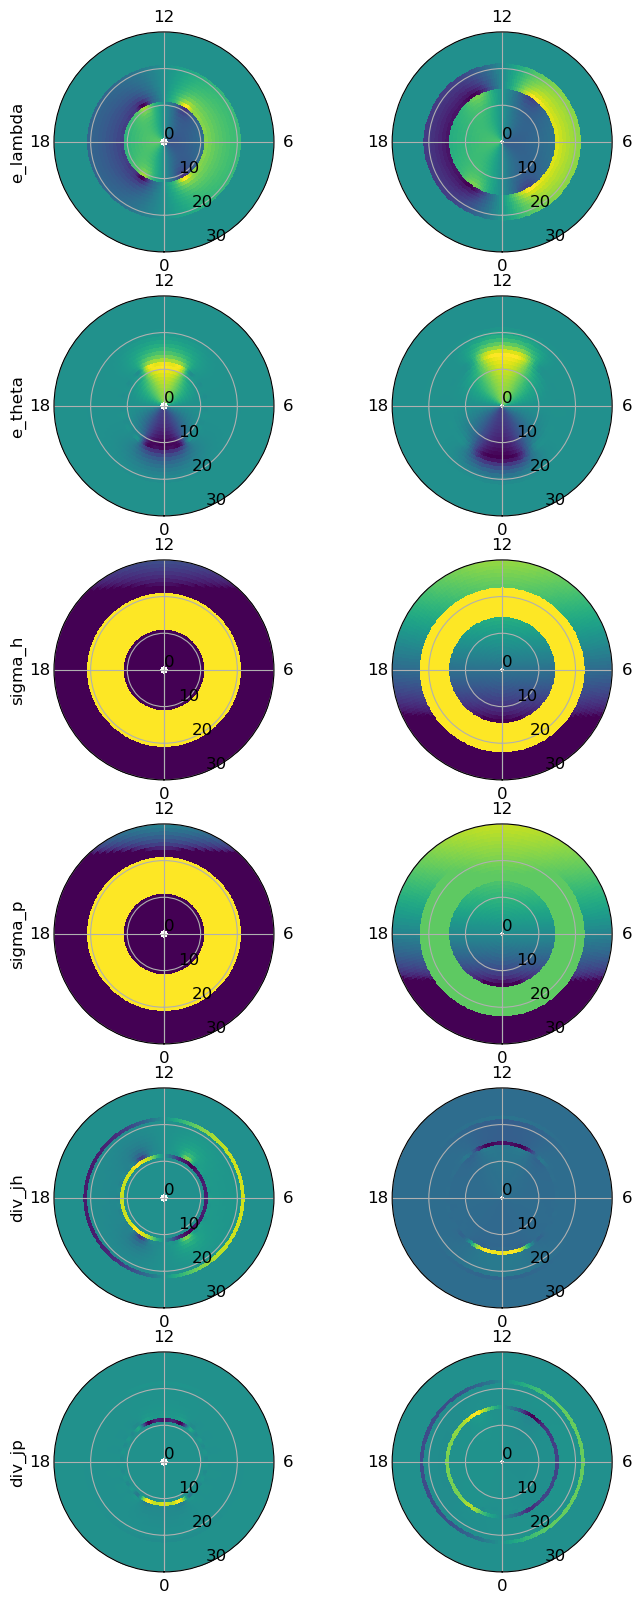

In [111]:
from johncoxon.plot import configure_polar_plot

fig, ax = plt.subplots(6, 2, figsize=(8, 20), subplot_kw={"polar": True})

for row, variable in enumerate(["e_lambda", "e_theta", "sigma_h", "sigma_p", "div_jh", "div_jp"]):
    ax[row, 1].pcolormesh(np.radians(np.arange(0, 360, 2)), np.arange(40), 
                          sav[variable].T, shading="nearest")
    ax[row, 0].set_ylabel(variable, labelpad=20)

model_variables = [model.e_labda, model.e_theta, model.sigma_h, model.sigma_p, div_jh, div_jp]
for row, variable in enumerate(model_variables):
    ax[row, 0].pcolormesh(model.theta, model.colat, variable, shading="nearest")

for a in ax.flatten():
    configure_polar_plot(a, 30)